In [1]:
import pandas as pd
import pickle
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, LSTM, Dropout, BatchNorm1d, BatchNorm2d, Parameter, GRU
from torch.nn.functional import relu
from torch import tanh
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
file = open(r"data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-0_cleaned.pickle",'rb')
df1 = pickle.load(file)
file.close()
file = open(r"data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-1_cleaned.pickle",'rb')
df2 = pickle.load(file)
file.close()
df = pd.concat([df1, df2])

In [3]:
#df1 = df1.sample(frac=0.7)
#df2 = df2.sample(frac=0.7)

#df1.to_pickle(r"data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-0_cleaned.pickle")
#df2.to_pickle(r"data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-1_cleaned.pickle")


In [4]:
print(len(df))

2681


In [5]:
LOAD = True

### All transformations toggled below are performed based on the training set only
### Transformations are applied to all data sets

## Use min max scaling on zAcc and speed data
## Resulting values are put between MINIMUM and MAXIMUM (based on training min max)
NORMALIZE = True # True
MINIMUM = -1 #-1
MAXIMUM = 1 #1

## Downsample all sequences above the length quantile of the training set
## Ordering of the elements are kept
## Applied to zAcc sequences and speed sequences
QUANTILE = 0.9 # 0.9
DOWNSAMPLE = True #True
## Simply removes the rows affected
DOWNSAMPLE_BY_REMOVAL = False #False
assert(not (DOWNSAMPLE and DOWNSAMPLE_BY_REMOVAL))

## If true, use numpy repeat on all speed sequences followed by np.choice on indices to 
## have the length of speed sequences match the length of zAcc sequences
## If false, the model does it in the forward call (making the transformation volatile and non static)
#MATCH_LEN_DF = True

## If true, shuffles accZ and speed sequences on the first load
SHUFFLE = False #False
ONLY_SHUFFLE_TRAIN = False #False

## Sets the maximum IRI_mean value for the training set
TRAIN_IRI_MEAN_THRESHOLD = 4.5 #4.5

## Every row with an acceleration sequence lower than this will be cut from the overall data set
LOWER_ACCZ_LEN_CUTOFF = 1000 #1000


BATCH_SIZE = 1 #1

In [6]:
clean_df = df.copy()
clean_df = df.sample(frac=1).reset_index(drop=True)
clean_df = clean_df[['IRI_mean', 'GM.acc.xyz.z', 'GM.obd.spd_veh.value']]
clean_df = clean_df[clean_df['IRI_mean'] <= 4.5]
before_low_cut = len(clean_df)
clean_df = clean_df[clean_df['GM.acc.xyz.z'].apply(lambda x: len(x)) > LOWER_ACCZ_LEN_CUTOFF]
print('removed {:.2f}% of train/val/test samples by low cutoff'.format((before_low_cut-len(clean_df))/before_low_cut*100))

removed 3.45% of train/val/test samples by low cutoff


In [7]:
set_fractions = [0.80, 0.10, 0.10]
assert(sum(set_fractions) <= 1)

train_len = round(len(clean_df) * set_fractions[0])
val_len = round(len(clean_df) * set_fractions[1])
test_len = round(len(clean_df) * set_fractions[2])
train_set, validation_set, test_set = clean_df[:train_len].copy(), clean_df[train_len:train_len+val_len].copy(), clean_df[train_len+val_len:min(train_len+val_len+test_len,len(clean_df))].copy()


full_df = df.copy()
full_df = full_df[['IRI_mean', 'GM.acc.xyz.z', 'GM.obd.spd_veh.value']]
full_df = full_df[full_df['GM.acc.xyz.z'].apply(lambda x: len(x)) > LOWER_ACCZ_LEN_CUTOFF]

maxAcc = max(train_set['GM.acc.xyz.z'].apply(lambda x: max(x)))
minAcc = min(train_set['GM.acc.xyz.z'].apply(lambda x: min(x)))
maxSpeed = max(train_set['GM.obd.spd_veh.value'].apply(lambda x: max(x)))
minSpeed = min(train_set['GM.obd.spd_veh.value'].apply(lambda x: min(x)))

def normalizeDF(df):
    result = df.copy()
    result['GM.acc.xyz.z'] = result['GM.acc.xyz.z'].apply(lambda l: np.array([(x-minAcc)/(maxAcc-minAcc) * (MAXIMUM-MINIMUM) + MINIMUM for x in l]))
    result['GM.obd.spd_veh.value'] = result['GM.obd.spd_veh.value'].apply(lambda l: np.array([(x-minSpeed)/(maxSpeed-minSpeed) * (MAXIMUM-MINIMUM) + MINIMUM for x in l]))
    
    #result['GM.acc.xyz.z'].apply(lambda l: np.random.shuffle(l))
    #result['GM.obd.spd_veh.value'].apply(lambda l: np.random.shuffle(l))
    
    return result

train_set = train_set[train_set['IRI_mean'] <= TRAIN_IRI_MEAN_THRESHOLD]

if(NORMALIZE):
    train_set = normalizeDF(train_set)
    validation_set = normalizeDF(validation_set)
    test_set = normalizeDF(test_set)

In [8]:
#downsample large sequences
from numpy.random import choice

to_lengths_dict = {}
input_feats = ['GM.acc.xyz.z', 'GM.obd.spd_veh.value']
for feat in input_feats:
    a = train_set[feat].apply(lambda seq: seq.shape[0])
    l = int(a.quantile(QUANTILE))
    to_lengths_dict[feat] = l
    print(to_lengths_dict)
    
def downsample(x, to_len):
    idx = np.arange(len(x))
    idx = choice(idx, to_len, replace=False)
    idx.sort()
    return x.take(idx)
    
if(DOWNSAMPLE):
    for (k,v) in to_lengths_dict.items():
        train_set[k] = train_set[k].apply(lambda x: downsample(x,v) if len(x) > v else x)
        validation_set[k] = validation_set[k].apply(lambda x: downsample(x,v) if len(x) > v else x)
        test_set[k] = test_set[k].apply(lambda x: downsample(x,v) if len(x) > v else x)
elif(DOWNSAMPLE_BY_REMOVAL):
    before_downsample_removal = len(train_set) + len(validation_set) + len(test_set)
    train_set = train_set[train_set['GM.acc.xyz.z'].apply(lambda x: len(x)) < to_lengths_dict['GM.acc.xyz.z']]
    validation_set = validation_set[validation_set['GM.acc.xyz.z'].apply(lambda x: len(x)) < to_lengths_dict['GM.acc.xyz.z']]
    test_set = test_set[test_set['GM.acc.xyz.z'].apply(lambda x: len(x)) < to_lengths_dict['GM.acc.xyz.z']]
    after_downsample_removal = len(train_set) + len(validation_set) + len(test_set)
    print('removed {:.2f}% of train/val/test samples by high cutoff'.format((before_downsample_removal-after_downsample_removal)/before_downsample_removal*100))
    
#for (k,v) in to_lengths_dict.items():
#    clean_df[k] = clean_df[k].apply(lambda x: choice(x, v) if len(x) > v else x)
#    full_df[k] = full_df[k].apply(lambda x: choice(x, v) if len(x) > v else x)

print(max(train_set['GM.acc.xyz.z'].apply(lambda x: len(x))))
print(max(validation_set['GM.acc.xyz.z'].apply(lambda x: len(x))))
print(max(test_set['GM.acc.xyz.z'].apply(lambda x: len(x))))

{'GM.acc.xyz.z': 6342}
{'GM.acc.xyz.z': 6342, 'GM.obd.spd_veh.value': 1142}
6342
6342
6342


In [9]:
def matchLen(row):
    seq_len = len(row['GM.acc.xyz.z'])
    speed = row['GM.obd.spd_veh.value']
    speed_len = len(speed)
    multi = seq_len // speed_len + 1
    speed = speed.repeat(multi)
    speed = downsample(speed, seq_len)
    row['GM.obd.spd_veh.value'] = speed
    return row

def matchLenDF(df):
    result = df.copy()
    result = result.apply(lambda row: matchLen(row), axis=1)
    return result
   
#if(MATCH_LEN_DF):
if(True):
    train_set = matchLenDF(train_set)
    validation_set = matchLenDF(validation_set)
    test_set = matchLenDF(test_set)

In [10]:
if(LOAD):
    SUFFIX = '2911-5'
    test_set = pd.read_pickle('test_set{}.pkl'.format(SUFFIX))
    train_set = pd.read_pickle('train_set{}.pkl'.format(SUFFIX))
    validation_set = pd.read_pickle('validation_set{}.pkl'.format(SUFFIX))

In [11]:
import statistics
print(train_set['GM.acc.xyz.z'].apply(lambda x: statistics.median(x)).median())
print(train_set['GM.obd.spd_veh.value'].apply(lambda x: statistics.median(x)).median())
print(validation_set['GM.acc.xyz.z'].apply(lambda x: statistics.median(x)).median())
print(validation_set['GM.obd.spd_veh.value'].apply(lambda x: statistics.median(x)).median())
print(test_set['GM.acc.xyz.z'].apply(lambda x: statistics.median(x)).median())
print(test_set['GM.obd.spd_veh.value'].apply(lambda x: statistics.median(x)).median())

-0.372162386081193
0.428684376976597
-0.372162386081193
0.4408602150537635
-0.372162386081193
0.43042378241619217


In [12]:
import torch.utils.data as data_utils
import torch
import torch.nn.utils.rnn as rnn_utils

use_cuda = torch.cuda.is_available()

In [13]:
import torch.nn.utils.rnn as rnn_utils

def loader(df, force_no_shuffle = False):
    data = []
    for i in range(len(df)):
        accZSequence = df['GM.acc.xyz.z'].values[i]
        speedSequence = df['GM.obd.spd_veh.value'].values[i]
        
        if(SHUFFLE and force_no_shuffle == False):
            np.random.shuffle(accZSequence)
            np.random.shuffle(speedSequence)
        
        data.append((torch.tensor(accZSequence), torch.tensor(speedSequence)))
    return data

def collate(batch):
    accZSequences, speedSequences = zip(*batch)
    accZSequences = rnn_utils.pad_sequence(accZSequences, batch_first=True).float()
    speedSequences = rnn_utils.pad_sequence(speedSequences, batch_first=True).float()
    return {
        'accZ': accZSequences, 
        'speed': speedSequences
    }

def get_variable(x):
    if use_cuda:
        return x.cuda()
    return x

def get_variable_obj(t):
    o = {}
    for (k,v) in t.items():
        o[k] = get_variable(v)
    return o

def get_numpy(x):
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

train_data = loader(train_set)
validation_data = loader(validation_set, force_no_shuffle=ONLY_SHUFFLE_TRAIN)
test_data = loader(test_set, force_no_shuffle=ONLY_SHUFFLE_TRAIN)
train_loader = data_utils.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate)
validation_loader = data_utils.DataLoader(validation_data, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate)
test_loader = data_utils.DataLoader(test_data, batch_size = 1, shuffle = False, collate_fn = collate)

In [14]:
class Encoder(nn.Module):
    def __init__(
        self,
        hidden_dim,
        enc_dim,
        match_len = False,
    ):
        super(Encoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.enc_dim = enc_dim
        self.match_len = match_len
        
        self.rnn1 = LSTM( #LSTM
            2,
            hidden_dim,
            batch_first = True,
        )
        
        self.rnn2 = LSTM( #LSTM
            hidden_dim,
            enc_dim,
            batch_first = True,
        )
        
    def forward(
        self, 
        x,
    ):
        zAcc, speed = x['accZ'], x['speed']
        batch_size = zAcc.shape[0]
        seq_len = zAcc.shape[1]
        
        ## If MATCH_LEN_DF is false, uncomment block below
        #speed_seq_len = speed.shape[1]
        #if(self.match_len == False):
        #    multi = seq_len // speed_seq_len + 1
        #    speed = torch.repeat_interleave(speed, multi, dim=1)
        #    idx = torch.ones(speed.shape[0],speed.shape[1]).to(zAcc.device)
        #    idx = idx.multinomial(seq_len, replacement=False)
        #    idx = idx.sort()[0]
        #    speed = torch.gather(speed, 1, idx)
        
        zAcc = zAcc.reshape(batch_size, seq_len, 1)
        speed = speed.reshape(batch_size, seq_len, 1)
        x = torch.cat((zAcc, speed), -1)
        x, _ = self.rnn1(x)
        x, (hn, _) = self.rnn2(x)
        hn = hn.reshape(batch_size, self.enc_dim)
        
        return hn
    
class Decoder(nn.Module):
    def __init__(
        self,
        enc_dim,
        hidden_dim,
    ):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.enc_dim = enc_dim
        
        self.rnn1 = LSTM( #LSTM
            enc_dim,
            hidden_dim,
            batch_first = True
        )
        
        self.rnn2 = LSTM( #LSTM
            hidden_dim,
            hidden_dim,
            batch_first = True
        )
        
        self.output = Linear(
            hidden_dim,
            1,
        )
        
        
    def forward(
        self,
        x,
        seq_len,
    ):
        batch_size = x.shape[0]
        x = x.repeat(1, seq_len)
        x = x.reshape(batch_size, seq_len, self.enc_dim)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.output(x)
        x = x.reshape(batch_size, seq_len)
        return x

In [15]:
class RA(nn.Module):
    def __init__(
        self, 
        enc_dim = 128,
        hidden_dim_enc = 256,
        hidden_dim_dec = 256,
        match_len = False,
    ):
        super(RA, self).__init__()
        
        self.encoder = Encoder(hidden_dim_enc, enc_dim, match_len)
        self.decoder = Decoder(enc_dim, hidden_dim_dec)
        
    def forward(self, x):
        seq_len = x['accZ'].shape[1]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)
        return x

In [16]:
net = None
net = RA(
    enc_dim = 96, #12
    hidden_dim_enc = 192, #18
    hidden_dim_dec = 192, #18
    #match_len = MATCH_LEN_DF,
)

if use_cuda:
    net.cuda()

print(net)

RA(
  (encoder): Encoder(
    (rnn1): LSTM(2, 192, batch_first=True)
    (rnn2): LSTM(192, 96, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(96, 192, batch_first=True)
    (rnn2): LSTM(192, 192, batch_first=True)
    (output): Linear(in_features=192, out_features=1, bias=True)
  )
)


In [17]:
if(LOAD):
    SUFFIX = '2911-5'
    
    oldNetDict = torch.load('model{}.pth'.format(SUFFIX))
    oldNet = RA(
        enc_dim = 96, #12
        hidden_dim_enc = 192, #18
        hidden_dim_dec = 192, #18
    )
    oldNet.load_state_dict(oldNetDict)
    oldNet.eval()
    net = oldNet
    net.cuda()
    print(net)

RA(
  (encoder): Encoder(
    (rnn1): LSTM(2, 192, batch_first=True)
    (rnn2): LSTM(192, 96, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(96, 192, batch_first=True)
    (rnn2): LSTM(192, 192, batch_first=True)
    (output): Linear(in_features=192, out_features=1, bias=True)
  )
)


In [18]:
TRAIN = False

LR = 6e-4 #6e-4
wd = 2e-5 #2e-5
criterion = nn.L1Loss(reduction='sum').cuda()
optimizer = optim.Adam(
    net.parameters(), 
    lr=LR, 
    weight_decay=wd
)

epochs = 5 #1
train_hist = []
val_hist = []


if(TRAIN):
    for epoch in range(1, epochs + 1):
        net.train()

        train_losses = []
        totBatches = len(train_loader)
        cBatch = 1
        for data in train_loader:
            optimizer.zero_grad()

            data = get_variable_obj(data)
            pred = net(data)

            loss = criterion(pred, data['accZ'])

            loss.backward()
            optimizer.step()

            train_losses.append(get_numpy(loss) / BATCH_SIZE)
            print('{}/{} batches, mean 10 last losses: {:.4f}'.format(cBatch, totBatches, np.mean(train_losses[-10:])), end='\r')
            cBatch = cBatch + 1


        val_losses = []
        net.eval()

        with torch.no_grad():
            for data in validation_loader:
                data = get_variable_obj(data)

                pred = net(data)

                loss = criterion(pred, data['accZ'])
                val_losses.append(get_numpy(loss) / BATCH_SIZE)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        print('                                                                                      ', end='\r')
        print('Epoch {}, trfain loss {:.4f}'.format(epoch, train_loss))
        print('Epoch {}, val loss {:.4f}'.format(epoch, val_loss))

        train_hist.append(train_loss)
        val_hist.append(val_loss)


96.19021                          
94.59587                          


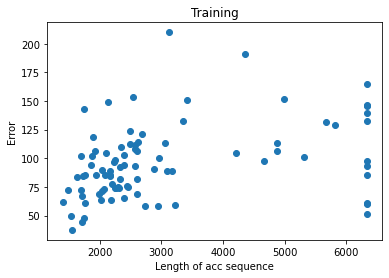

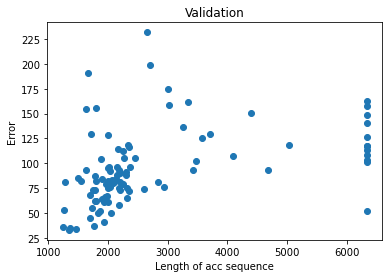

In [19]:
net.eval()
with torch.no_grad():
    train_losses = []
    train_lens = []
    for i, data in enumerate(train_loader):
        if(np.random.rand() > 0.04):
            continue
        print('{}/{}'.format(i,len(train_loader)), end='\r')
        data = get_variable_obj(data)

        labels = data['accZ']
        pred = net(data)

        loss = criterion(pred, labels)
        train_losses.append(get_numpy(loss) / BATCH_SIZE)
        train_lens.append(data['accZ'].shape[1])
    print('                                  ', end='\r')
    print('{:.5f}'.format(np.mean(train_losses)))

    val_losses = []
    val_lens = []
    for i, data in enumerate(validation_loader):
        if(np.random.rand() > 0.30):
            continue
        print('{}/{}'.format(i,len(validation_loader)), end='\r')
        data = get_variable_obj(data)

        labels = data['accZ']
        pred = net(data)

        loss = criterion(pred, labels)
        val_losses.append(get_numpy(loss) / BATCH_SIZE)
        val_lens.append(data['accZ'].shape[1])
    print('                                  ', end='\r')
    print('{:.5f}'.format(np.mean(val_losses)))

train_lens_sorted = [x for x,y in sorted(zip(train_lens, train_losses), key=lambda pair: pair[0])]
train_losses_sorted = [y for x,y in sorted(zip(train_lens, train_losses), key=lambda pair: pair[0])]
plt.title('Training')
plt.scatter(train_lens_sorted, train_losses_sorted)
plt.ylabel('Error')
plt.xlabel('Length of acc sequence')
plt.show()

val_lens_sorted = [x for x,y in sorted(zip(val_lens, val_losses), key=lambda pair: pair[0])]
val_losses_sorted = [y for x,y in sorted(zip(val_lens, val_losses), key=lambda pair: pair[0])]
plt.title('Validation')
plt.scatter(val_lens_sorted, val_losses_sorted)
plt.ylabel('Error')
plt.xlabel('Length of acc sequence')
plt.show()

In [20]:
anomaly_test_size_frac = 0.5 #0.5
anomaly_test_size = round(len(test_set)*(anomaly_test_size_frac/(1-anomaly_test_size_frac)))

assert(anomaly_test_size <= len(df[df['IRI_mean'] > 4.5]))

In [21]:
test_anomaly_df = full_df.copy()
test_anomaly_df = test_anomaly_df[test_anomaly_df['IRI_mean'] > 4.5]

if(DOWNSAMPLE):
    for (k,v) in to_lengths_dict.items():
        test_anomaly_df[k] = test_anomaly_df[k].apply(lambda x: downsample(x,v) if len(x) > v else x)
elif(DOWNSAMPLE_BY_REMOVAL):
    test_anomaly_df = test_anomaly_df[test_anomaly_df['GM.acc.xyz.z'].apply(lambda x: len(x)) < to_lengths_dict['GM.acc.xyz.z']]

test_anomaly_df = test_anomaly_df.sample(n = anomaly_test_size)

if(NORMALIZE):
    test_anomaly_df = normalizeDF(test_anomaly_df)

#if(MATCH_LEN_DF):
if(True):
    test_anomaly_df = matchLenDF(test_anomaly_df)
    

print(test_anomaly_df['GM.acc.xyz.z'].apply(lambda x: statistics.median(x)).median())
print(test_anomaly_df['GM.obd.spd_veh.value'].apply(lambda x: statistics.median(x)).median())

-0.372162386081193
0.20548703352308656


In [22]:
anomaly_lens = test_anomaly_df['GM.acc.xyz.z'].apply(lambda x: len(x))
test_set_lens = test_set['GM.acc.xyz.z'].apply(lambda x: len(x))

In [23]:
assert(max(test_set['IRI_mean']) <= 4.5)
assert(min(test_anomaly_df['IRI_mean']) > 4.5)

In [24]:
anomaly_data = loader(test_anomaly_df, force_no_shuffle=ONLY_SHUFFLE_TRAIN)
anomaly_loader = data_utils.DataLoader(anomaly_data, batch_size = 1, shuffle = False, collate_fn = collate)

recon_normal = []
recon_anomaly = []

net.eval()

with torch.no_grad():
    totlen = len(anomaly_loader)
    for i, e in enumerate(anomaly_loader):
        e = get_variable_obj(e)
        result = net(e)
        target = e['accZ']
        loss = get_numpy(criterion(result, target)).item()
        recon_anomaly.append(loss)
        if(i%10==0):
            print('{}/{}'.format(i,totlen), end='\r')

    print('anomaly done')

    totlen = len(test_loader)            
    for i, e in enumerate(test_loader):
        e = get_variable_obj(e)
        result = net(e)
        target = e['accZ']
        loss = get_numpy(criterion(result, target)).item()
        recon_normal.append(loss)
        if(i%10==0):
            print('{}/{}'.format(i,totlen), end='\r')

    print('conform done')

anomaly done
conform done


In [25]:
statistics.median(recon_normal)

87.62258911132812

In [26]:
statistics.median(recon_anomaly)

148.2278594970703

In [27]:
reconAll = []
reconAll.extend(recon_normal)
reconAll.extend(recon_anomaly)
targets = []
targets.extend([0 for i in range(len(recon_normal))])
targets.extend([1 for i in range(len(recon_anomaly))])

In [28]:
len(reconAll)

612

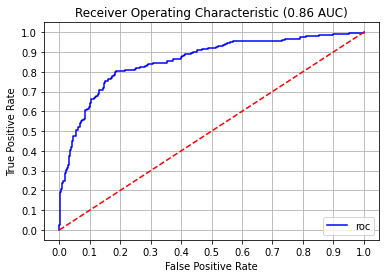

115.42048645019531
0.6176470588235294
0.18627450980392157
0.803921568627451


In [29]:
import sklearn.metrics as metrics
import seaborn as sns
fpr, tpr, thresholds = metrics.roc_curve(targets, reconAll)
auc = metrics.roc_auc_score(targets, reconAll) #0.88
plt.title('Receiver Operating Characteristic ({:.2f} AUC)'.format(auc))
plt.plot(fpr, tpr, 'b', label = 'roc')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.grid()
plt.xticks(np.arange(0.0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.01, 0.1))
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
c = tpr-fpr
idx = np.argmax(c)
print(thresholds[idx])
print(c[idx])
print(fpr[idx]) #
print(tpr[idx]) #
roc_optimal_threshold = thresholds[idx]

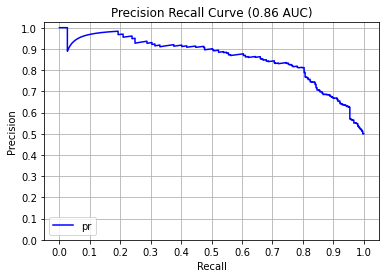

115.42048645019531
0.8078817733990149
0.8118811881188119
0.803921568627451


In [30]:
precision, recall, thresholds = metrics.precision_recall_curve(targets, reconAll)
auc = metrics.auc(recall, precision)
plt.title('Precision Recall Curve ({:.2f} AUC)'.format(auc))
plt.plot(recall, precision, 'b', label = 'pr')
plt.legend(loc = 'lower left')
plt.grid()
plt.xticks(np.arange(0.0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.01, 0.1))
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)
print(thresholds[idx])
print(fscore[idx])
print(precision[idx])
print(recall[idx])
prc_optimal_threshold = thresholds[idx]

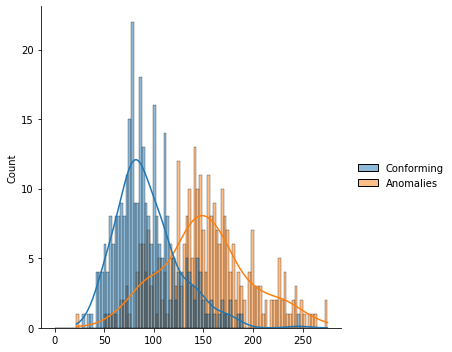

In [31]:
sns.displot({'Conforming': recon_normal, 'Anomalies': recon_anomaly}, bins=np.arange(0.0,max(recon_anomaly),max(recon_anomaly)/100), kde=True)
plt.show()

In [32]:
def score(row):
    acc = row['GM.acc.xyz.z']#.to_numpy()
    #acc = acc[0]
    acc = torch.tensor(acc).view(1,-1).float()
    speed = row['GM.obd.spd_veh.value']#.to_numpy()
    #speed = speed[0].astype(float)
    speed = torch.tensor(speed).view(1,-1).float()
    e = {
        'accZ': acc,
        'speed': speed,
    }
    e = get_variable_obj(e)
    result = net(e)
    target = e['accZ']
    loss = get_numpy(criterion(result, target)).item()
    return loss
    
anom_score_df = test_anomaly_df.copy()
anom_score_df['score'] = anom_score_df.apply(lambda x: score(x), 1)
test_score_df = test_set.copy()
test_score_df['score'] = test_score_df.apply(lambda x: score(x), 1)

In [33]:
import math
def plotScores(df, title, threshold):
    ## This shows the correlation between IRI mean of the anomalies and their scores
    ## For a rising trend, it would be tempting to train on a sligthly skewed training set (max iri of eg 4.3 on training)
    ## This would however, also have negative effects, as the AE will score worse on the conforming data between 4.3 and 4.5 too
    ## In the real world, there are probably more conforming road than anomalous, so this would be amplified
    scores = df['score'].values
    means = df['IRI_mean'].values

    means_sorted = [x for x,y in sorted(zip(means, scores), key=lambda pair: pair[0])]
    scores_sorted = [y for x,y in sorted(zip(means, scores), key=lambda pair: pair[0])]
    plt.title(title)
    plt.scatter(means_sorted, scores_sorted)#, 'b', label = 'pr')
    plt.plot([min(df['IRI_mean']), max(df['IRI_mean'])], [threshold, threshold], 'r--', label='threshold')
    plt.ylabel('Loss')
    plt.xlabel('IRI_mean value')
    plt.legend()
    plt.show()
    
def distAcc(df, max_IRI_mean, title, threshold, anomalies = True):
    missed = df[df['score'] <= threshold]
    caught = df[df['score'] > threshold]
    if(anomalies == False):
        missed, caught = caught, missed
    missed_scores = missed['IRI_mean'].values
    caught_scores = caught['IRI_mean'].values
    bins = math.ceil(max_IRI_mean)*10
    #max(df['IRI_mean'])-4.5
    a = sns.displot({'Correctly Labeled': caught_scores, 'Mislabeled': missed_scores, }, bins=bins, kde=True)
    plt.yticks(np.arange(0, a.ax.dataLim.y1 + 1, max(1,a.ax.dataLim.y1 // 10)))
    plt.title(title)
    plt.show()
    return caught, missed

In [34]:
max_IRI_mean = max(df['IRI_mean'])-4.5
#opt_threshold = (roc_optimal_threshold + prc_optimal_threshold)/2
opt_threshold = prc_optimal_threshold

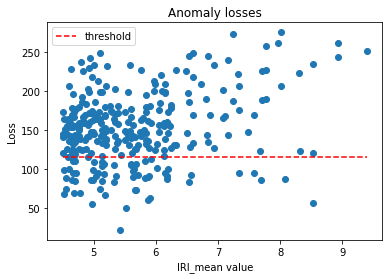

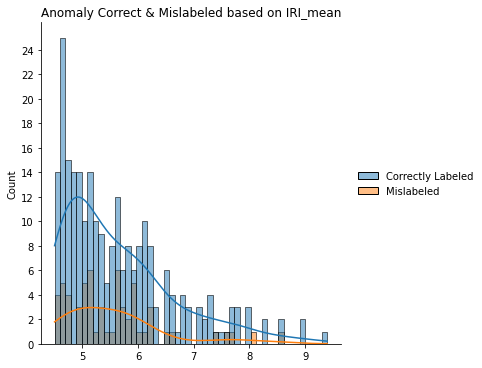

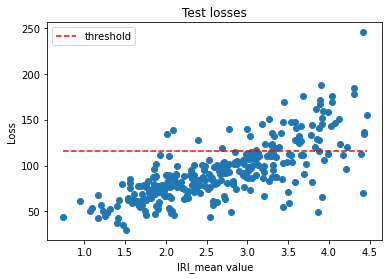

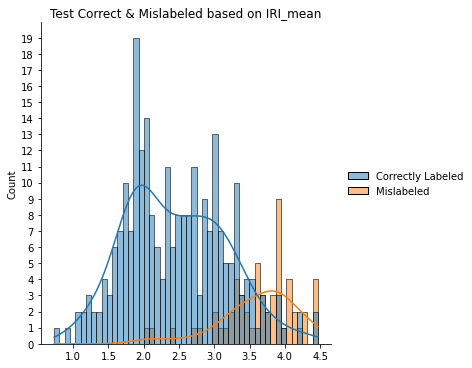

In [35]:
plotScores(anom_score_df, 'Anomaly losses', opt_threshold)
caught, missed = distAcc(anom_score_df, max_IRI_mean, 'Anomaly Correct & Mislabeled based on IRI_mean', opt_threshold, anomalies = True)
plotScores(test_score_df, 'Test losses', opt_threshold)
caught2, missed2 = distAcc(test_score_df, max_IRI_mean, 'Test Correct & Mislabeled based on IRI_mean', opt_threshold, anomalies = False)
caught = caught.append(caught2)
missed = missed.append(missed2)
caught_scores = caught['IRI_mean'].values
missed_scores = missed['IRI_mean'].values

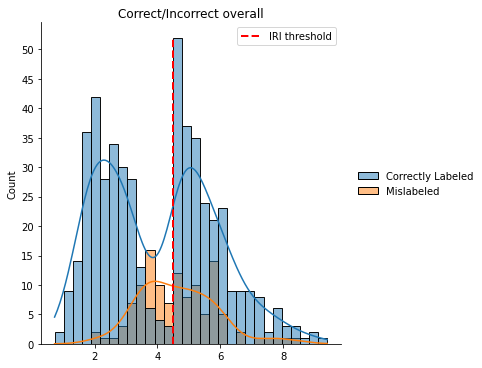

In [36]:
bins = math.ceil(max_IRI_mean)*6 # fiddle to make the dashed line fit between bins
a = sns.displot({'Correctly Labeled': caught_scores, 'Mislabeled': missed_scores, }, bins=bins, kde=True)
            
plt.yticks(np.arange(0, a.ax.dataLim.y1 + 1, max(1,a.ax.dataLim.y1 // 10)))
plt.plot([4.5,4.5],[a.ax.dataLim.y0,a.ax.dataLim.y1], 'r--', label='IRI threshold', lw=2)
plt.legend()
plt.title('Correct/Incorrect overall')
plt.show()

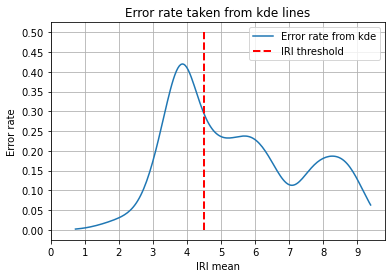

In [37]:
lines = []

for i in a.ax.get_children():
    if(type(i) == plt.Line2D):
        if(i.get_label() != 'IRI threshold'):
            lines.append(i)

line1 = lines[0]
line2 = lines[1]
line1x = line1.get_xdata()
line1y = line1.get_ydata()
line2x = line2.get_xdata()
line2y = line2.get_ydata()
newLineX, newLineY = line1x, (line1y/(line2y+line1y))
sns.lineplot(x=newLineX, y=newLineY, label='Error rate from kde')
plt.plot([4.5,4.5],[0,0.5], 'r--', label='IRI threshold', lw=2)
plt.xticks(np.arange(0,9.1,1))
plt.xlabel('IRI mean')
plt.yticks(np.arange(0,0.51,0.05))
plt.ylabel('Error rate')
plt.title('Error rate taken from kde lines')
plt.grid()
plt.legend()
plt.show()

In [38]:
SAVE = False
if(SAVE):
    SUFFIX = '2911-5'
    torch.save(net.state_dict(), 'model{}.pth'.format(SUFFIX))
    test_set.to_pickle('test_set{}.pkl'.format(SUFFIX))
    train_set.to_pickle('train_set{}.pkl'.format(SUFFIX))
    validation_set.to_pickle('validation_set{}.pkl'.format(SUFFIX))

In [39]:
print(len(train_set))
print(len(validation_set))
print(len(test_set))
print(len(test_anomaly_df))

2446
306
306
306
